# Collaboration and Competition - Learning to Play Tennis with MADDPG

---

In this notebook, we will teach two agents two play tennis using Multi-Agent Deep Deterministic Policy Gradient (MADDPG) in the Unity ML-Agents Tennis Environment.

### 1. Start the Environment

We begin by importing the necessary packages. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from maddpg import MADDPG
import pandas as pd
import matplotlib.pyplot as plt

Next, we will start the environment.

In [2]:
env = UnityEnvironment(file_name=r"Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Train the agents using MADDPG

Let's now use the following function to traing the agents with MADDPG

In [5]:
def train_maddpg(n_episodes=1000, print_every=100):
    """Train Multi-agent Deep Deterministic Policy Gradient (MADDPG).

    Parameters
    ----------
    n_episodes : int
        Maximum number of training episodes
    print_every : int
        At every `print_every` episode, the average score is printed

    Returns
    -------
    scores : list
        Total reward per episode
    """
    seed = np.random.randint(1e6)
    maddpg_main = MADDPG(num_agents, state_size, action_size, seed=seed)

    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        maddpg_main.reset()  # Reset the OU noise of each agent
        scores_episode = np.zeros(num_agents)  # initialize score value calculations for 2 agents

        while True:
            actions = maddpg_main.act(states)  # get actions from both agents
            env_info = env.step(actions)[brain_name]  # send actions to the environment
            next_states = env_info.vector_observations  # get next states
            rewards = env_info.rewards  # get rewards
            dones = env_info.local_done  # see if episodes finished
            maddpg_main.step(states, actions, rewards, next_states, dones)  # perform optimization for both agents
            scores_episode += rewards
            states = next_states
            if np.any(dones):
                break

        score = np.max(scores_episode)
        scores_deque.append(score)
        scores.append(score)

        # Display score info
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.4f}\tCurrent Score: {score:.5f}'
              f'\t Max Score: {np.max(scores):.5f}', end="")

        # Print average score to the screen at every `print_every`
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_deque):.4f}')

        # Save model parameters if the training is successful
        if np.mean(scores_deque) >= 0.5:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_deque):.4f}')
            maddpg_main.saveModelParams()
            break
    
    env.close()
    return scores

scores = train_maddpg(n_episodes=2000)

Episode 100	Average Score: 0.0086	Current Score: 0.10000	 Max Score: 0.10000
Episode 200	Average Score: 0.0050	Current Score: 0.00000	 Max Score: 0.10000
Episode 300	Average Score: 0.0476	Current Score: 0.10000	 Max Score: 0.20000
Episode 400	Average Score: 0.0830	Current Score: 0.10000	 Max Score: 0.40000
Episode 500	Average Score: 0.1439	Current Score: 0.30000	 Max Score: 0.70000
Episode 600	Average Score: 0.2635	Current Score: 0.10000	 Max Score: 1.60000
Episode 666	Average Score: 0.5135	Current Score: 2.10000	 Max Score: 2.60000
Environment solved in 566 episodes!	Average Score: 0.5135


### 4. Plotting

Let's look at the result.

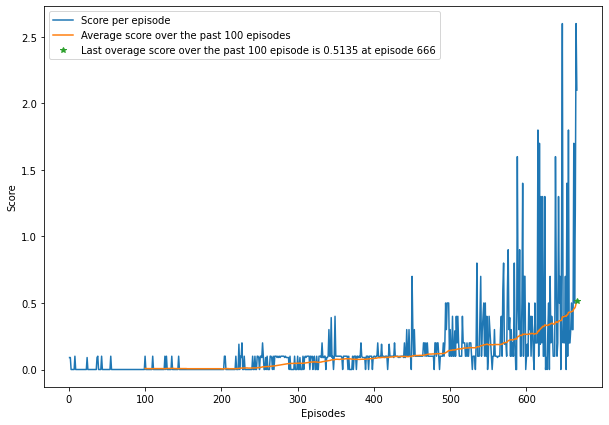

In [6]:
rolling_mean = pd.Series(scores).rolling(100).mean().to_numpy()

# plot the scores
fig, ax = plt.subplots(figsize=(10, 7))
iep = np.arange(1, len(scores)+1)
ax.plot(iep, scores, label='Score per episode')
ax.plot(iep, rolling_mean, label='Average score over the past 100 episodes')
ax.plot(iep[-1], rolling_mean[-1], '*', label=f'Last overage score over the past 100 episode is {rolling_mean[-1]:.4f} at episode {iep[-1]}')
ax.set_xlabel('Episodes')
ax.set_ylabel('Score')
ax.legend()
plt.show()